In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRY = "Yemen"

In [4]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [5]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [6]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [7]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [8]:
TEST_SIZE = 30
FREQ = train.index.freq

In [9]:
TRAIN = train.copy()

In [10]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [11]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

In [12]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(train)
TEST_TARGET_SETS = find_multiple_sets(test)

## Results from Grid Search

In [15]:
PATH_TO_RESULTS = "./isi_server/output2/"

In [16]:
results = pd.read_csv(PATH_TO_RESULTS + "grid_search.csv")
results.head()

,1 Month Anomaly (%) Rainfall,3 Months Anomaly (%) Rainfall,Cereals and tubers,Exchange rate (USD/LCU),FCS,Fatality,Lat,Lon,NDVI Anomaly,Population,Rainfall (mm),Ramadan,rCSI,h,val_loss,train_loss
0,NaN,11.0,96.0,NaN,71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,76.0,1,0.282149,0.005228
1,NaN,11.0,96.0,NaN,71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,76.0,2,1.121111,0.009716
2,NaN,11.0,96.0,NaN,71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,76.0,3,2.191779,0.011809
3,NaN,11.0,96.0,NaN,71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,76.0,4,3.660229,0.013327
4,NaN,11.0,96.0,NaN,71,NaN,NaN,NaN,NaN,0.0,NaN,NaN,76.0,5,6.328507,0.013360


## Forecasting

In [39]:
import xgboost as xgb

In [40]:
FORECASTING = test.copy()

In [46]:
for h in range(TEST_SIZE):
    # Get the best parameters for the prediction horizon h.
    lags_dict = results[results.h == (h+1)].loc[results[results.h == (h+1)].val_loss.idxmin()].drop(["h", "val_loss", "train_loss"]).to_dict()  
    for k,v in lags_dict.items():
        if v >= 1:
            lags_dict[k] = int(v)
        else:
            lags_dict[k] = None

    X_train_list, y_train_list = list(), list()
    X_test_dict = dict()
    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        for PROVINCE in PROVINCES:
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = True, validation = False, return_single_level = True, 
                                                                   dtype = np.float32)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)

    print("Training %s samples for the prediction horizon h: %d" % (str(X_train.shape), h+1), end = "\r")
    model = xgb.XGBRegressor(n_estimators = 100, objective = "reg:squarederror")   #tree_method = "gpu_hist", gpu_id = 0
    model.fit(X_train, y_train)  
    
    # Prediction.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)]
            y_hat = model.predict(X_test)[0]
            FORECASTING[(PROVINCE, "FCS")].loc[test_set.index[h]] = y_hat

In [47]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [48]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [49]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    loss = mean_squared_error(test_set, forecasting_set)
    losses.append(loss)
    loss_h = mean_squared_error(test_set.transpose(), forecasting_set.transpose(), multioutput = "raw_values")
    losses_h.append(loss_h)

In [50]:
np.mean(losses)

225.87465455198176

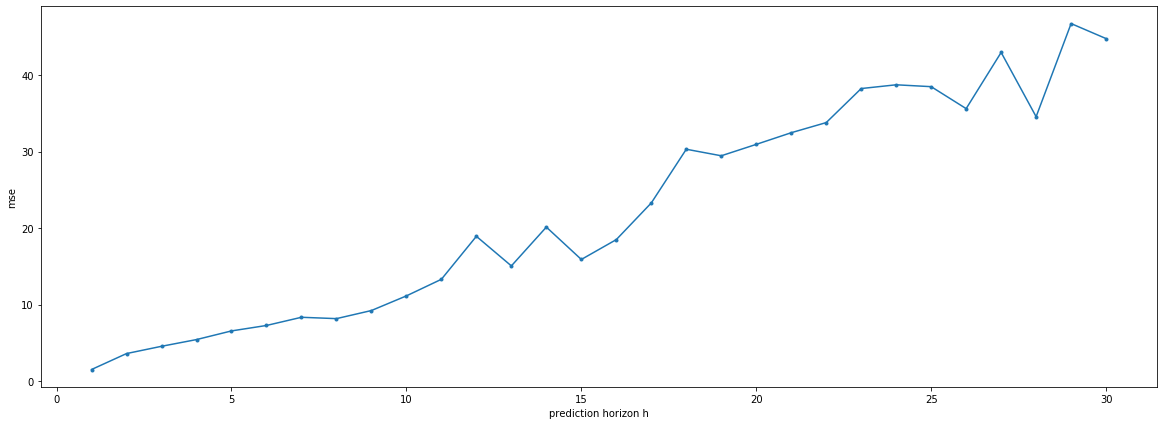

In [37]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10);